# Analysis Grand Challenge of the PHYSLITE data format

This notebook is written as the result of a project of the IRIS-HEP summer fellowship programme. The web page, dedicated to the project, can be found via the [link](https://iris-hep.org/fellows/Denys-Klekots.html).

The code below is heavily based on the Analysis Grand Challenge (AGC) of the CMS Open Data $t\bar{t}$. There is a link to the corresponding [GitHub repository](https://github.com/alexander-held/PyHEP-2022-AGC) written by Alexander Held.

Here we will use scientific Python infrastructure, which allows one to read data from the file and further analyse it. The data in high-energy physics is usually stored on an event-by-event basis and contains information on the detected particles. As there is an arbitrary number of particles for each event, we will use the `awkward` Python tools which allow us to handle arrays with an arbitrary length. The PHYSLITE format is stored inside a widely used in particle physics `*.root` file format and can be read by using the `coffee` python package. Also, the different events in high-energy physics are independent of each other, which allows for parallel computation and distribution over the cluster, the `dask` python package allows one to handle parallel computations.

In [1]:
import os
from pathlib import Path
import datetime
import re

import uproot
import awkward as ak
import dask
import cabinetry
import dask_awkward as dak
import numpy as np
import hist.dask

import warnings
warnings.filterwarnings("ignore")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools


from dask.distributed import Client, performance_report

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)

# Set up the client distribution calculation for coffea-opendata.casa. Change the URL for UChicago
client = Client("tls://localhost:8786")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The PHYSLITE format files used for this analysis contain a lot of information, organised in brunches, a description of which can be accessed via the [link](https://atlas-physlite-content-opendata.web.cern.ch/). For the purpose of this specific analysis, a few of them are used and a filter is applied to select used ones.

In [2]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights",
        ]

The code in the cell below will read the data from the file in a function `NanoEventsFactory.from_root(...)` and produce an awkward array, named `events` in this code. Here the `PHYSLITESchema` is specified to correspond to the format of the data. Also the delayed computation is specified, which makes Python construct the graph of tasks rather than execute code on each line. Finally, all tasks in a graph will be executed once the function `.compute()` is called (see below).

The file used in the next cell is one of the Montecarlo-generated files for the $t \bar{t}$ pair physical process of nominal variation. See the code below for more information and a reference to the file.

In [3]:
mc_file = "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000012.pool.root.1"


events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

### B-tagging discriminant

The DL1 flavour tagging algorithm is used for the pre-analysis of data, stored in the PHYSLITE format used in this analysis. The output of the DL1 algorithm is the $p_b$ $p_c$ and $p_u$ variables that are combined by the following formula to define the final discriminant on b-tagging

$$
D_{DL1} = log \left( \frac{p_b}{f_c \cdot p_c + (1-f_c) \cdot p_u} \right)
$$ 

The $p_b$ $p_c$ and $p_u$ are stored in the input file under fields (also known as brunches) named `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc` and `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu` respectively. For more information about discriminant value please refer to the following [link](https://ftag.docs.cern.ch/recommendations/algs/2019-recommendations/#algorithm-structure) (Please note that the CERN account might be needed for access). $f_c$ is the constant which equal to $f_c = 0.018$ in this analysis.

The jet is considered as b-tagged if the $D_{DL1}$ variable is above threshold. The threshold value of `2.456` was used here, which correspond to efficiency of 77%. Refer to the [link](https://ftag.docs.cern.ch/recommendations/algs/r22-preliminary/#working-point-definition-for-dl1dv01) for more information (please note that CERN account might be needed to access).

In [4]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    DDL1 = np.log(DDL1)

    return DDL1

## Event selections and observables

The point of this analysis's grand challenge is to make a benchmark of the PHYSLITE data format on the example of the study of the t quark production. All events in this analysis go through preselection stages which include the selection of transverse momentum ($p_t$) and the $\eta$ parameter of the leptons and jets.
Additional selections depend on the observable which is the following:
1) The mass of the trijet with the largest pt value uses events which contain at least four jets, at least two of them must be b-tagged and exactly one lepton. From all possible combinations of jets grouped in three the one group of three with the largest transverse momentum (vector sum) is chosen and invariant mass is calculated for those jets. Additionally, at least one b-tagged jet must be present in the group of three.
2) The $H_T$ observable value, which is the scalar sum transverse momentum of all jets in events. For this observable, the selected events must have at least four jets, exactly one of them must be b-tagged, and exactly one lepton must be present in the event.

The schematic view of the event with four jets (like the one used for the calculation of trijet mass) is presented in the following image. Here two b quarks are forming jets that are b-tagged. The other two quarks (which come from W boson decay) are not necessarily b-tagged. The charged lepton is also coming from the decay of other W bosons, and the neutrino is not detected in this experiment.

<div>
<img src="utils/ttbar.png" width="500"/>
</div>

The source of the image is the [AGC](https://github.com/alexander-held/PyHEP-2022-AGC/blob/main/talk.ipynb) notebook by Alexander Held.

### Notes on b-tagging variables in code

At the moment of writing of this code, the jets information are stored in the file under `AnalysisJetsAuxDyn` brunch name, at the same time the variables, used for calculation of the b-tagging discriminant, are stored in the brunch named `BTagging_AntiKt4EMPFlowAuxDyn` which is slightly inconvenient as one might prefer to have all jet information inside a single brunch. In the future, it might be added the possibility to the `PHYSLITESchema` to link the b-tagging info into the jet's branch, but for now, it is done manually in this example. 

In [5]:
B_TAG_THRESHOLD = 2.456

def calculate_preselections(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    # calculate tagging variable and manually attach it to jets (which passed the preselection)
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    
    return event_filters, selected_jets
    
def calculate_trijet_mass_and_ev_filter(event_filters, selected_jets):    
        
    # at least two b-tagged jets ("tag" means score above threshold)
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass), event_filters


def calculate_Ht_and_ev_filter(event_filters, selected_jets):
    
    # at exactly ont b-tagged jets ("tag" means score above threshold)
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) == 1)
    selected_jets = selected_jets[event_filters]
    
    observable_Ht = ak.sum(selected_jets.pt, axis=-1)
    
    return observable_Ht, event_filters


The code below does fill histograms for the trijet mass and the $H_t$ value.

In [6]:
event_filters, selected_jets = calculate_preselections(events)

reconstructed_top_mass, _ = calculate_trijet_mass_and_ev_filter(event_filters, selected_jets)
hist_reco_mtop = hist.dask.Hist.new.Reg(25, 50, 550, label="$m_{bjj} [GeV]$").Double().fill(reconstructed_top_mass/1000)

observable_Ht, _ = calculate_Ht_and_ev_filter(event_filters, selected_jets)
hist_Ht = hist.dask.Hist.new.Reg(25, 70, 570, label="$H_T$ [GeV/c]").Double().fill(observable_Ht/1000)

The code for processing the data written above is not executed until the `.compute()` method of the `hist_reco_mtop` is called. Such an approach of delayed computations allows highly improved efficiency of calculations.

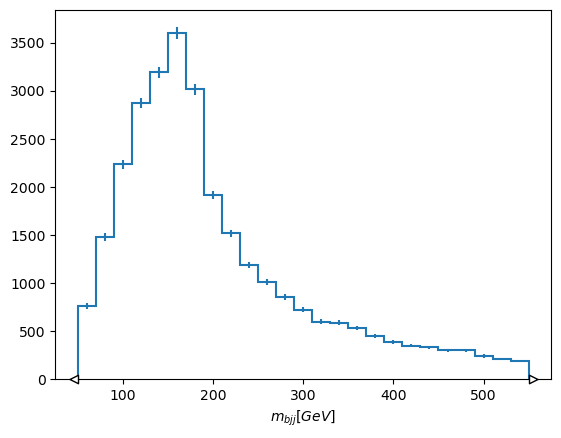

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

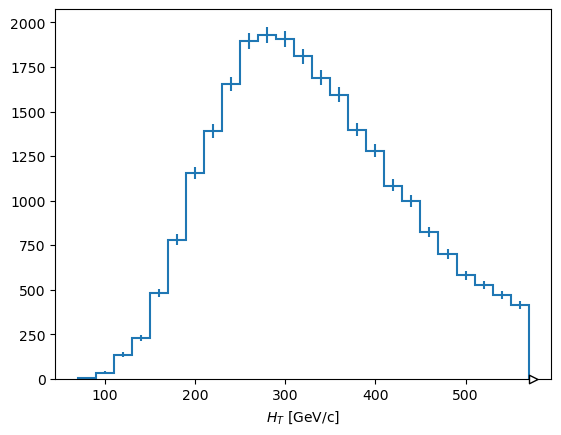

In [8]:
# perform computation and visualize
artists = hist_Ht.compute().plot()

# Distributed computations

Now we will move to the distributed computations. The code below applies the same approach to the selection of the data and calculation of the mass of the trijets and $H_T$. The further code uses multiple PHYSLITE files which have the same structure of branches and are processed in a parallel way, after which the results are merged in the final histogram.

The files used for distributed calculations and their metadata are specified in the cell below. This particular case uses Monte Carlo generated data which can be accessed via the [link](https://opendata.cern.ch/record/80017) and are `nominal` (as named in variation). To estimate the systematic uncertainties, the files from other Monte Carlo simulations are processed as well, those files are marked as `systematic_var` in variation and can be found via the [link](https://opendata.cern.ch/record/80018). The corresponding metadata (for both Monte Carlo simulation) can be accessed via the [link](https://opendata.atlas.cern/docs/documentation/overview_data/data_research_2024/#metadata). Please refer to the comments in the file_utils.py file for more information. 

TODO: Add a reference to W+jets files (record 80010 files)

The metadata is read from the metadata.csv file during the importing of `file_utils`. All of the available metadata for specific processes is stored, but only some of them are used (see below), this redundancy affects performance very little but is much more favourable from the code flexibility and user-friendliness point of view. 

Additionally, the label of physicall process is added to the metadata dictionary in the cell below, this label is used during the drawing of the histogram.

## Monte Carlo-simulated physical processes of $t$ quarks producing.

The processes of producing single top quarks and mater-antimatter $t \bar{t}$ pairs were simulated in the input data for this analysis. The Feynman diagrams of the leading order for single top processes are described in the picture. The original of the picture is Ref. [1]

<div>
<img src="utils/Single_quark_process_diagrams.png" width="1000"/>
</div>
The diagrams shows single top production: (a) - t-channel, (b) - Wt -channel, (c) s-channel.


[1] Precision Measurements of Top Quark Production with the ATLAS Detector. Philipp  Stolte. EPJ Web Conf. 137 08015 (2017). [DOI:10.1051/epjconf/201713708015](https://doi.org/10.1051/epjconf/201713708015)


In [13]:
import file_utils

XCACHE_PREFIX = "root://xcache.af.uchicago.edu:1094//"
# XCACHE_PREFIX = "" # This could be an empty string or one may like to add some prefix, for example, xcache or so.

fileset = {
"PowhegPythia8EvtGen_A14_singletop_schan_lept_top"  : 
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PowhegPythia8EvtGen_A14_singletop_schan_lept_top},
            'metadata': {**file_utils.metadata_PowhegPythia8EvtGen_A14_singletop_schan_lept_top, "process-label":"single top s chan.", "variation":"nominal"},
            },
"PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop},
            'metadata': {**file_utils.metadata_PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop, "process-label":"single top s chan.", "variation":"nominal"},
            },
"PhPy8EG_A14_tchan_BW50_lept_top":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PhPy8EG_A14_tchan_BW50_lept_top},
            'metadata': {**file_utils.metadata_PhPy8EG_A14_tchan_BW50_lept_top, "process-label":"single top t chan.", "variation":"nominal"},
            },
"PhPy8EG_A14_tchan_BW50_lept_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PhPy8EG_A14_tchan_BW50_lept_antitop},
            'metadata': {**file_utils.metadata_PhPy8EG_A14_tchan_BW50_lept_antitop, "process-label":"single top t chan.", "variation":"nominal"},
            },
"PhPy8EG_tW_dyn_DR_incl_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PhPy8EG_tW_dyn_DR_incl_antitop},
            'metadata': {**file_utils.metadata_PhPy8EG_tW_dyn_DR_incl_antitop, "process-label":"single top tW chan.", "variation":"nominal"},
            },
"PhPy8EG_tW_dyn_DR_incl_top":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PhPy8EG_tW_dyn_DR_incl_top},
            'metadata': {**file_utils.metadata_PhPy8EG_tW_dyn_DR_incl_top, "process-label":"single top tW chan.", "variation":"nominal"},
            },
#############################
## W and jets samples    
#############################
"Sh_2211_Wenu_maxHTpTV2_BFilter":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wenu_maxHTpTV2_BFilter},
            'metadata': {**file_utils.metadata_Sh_2211_Wenu_maxHTpTV2_BFilter, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wenu_maxHTpTV2_CFilterBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wenu_maxHTpTV2_CFilterBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wenu_maxHTpTV2_CFilterBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wenu_maxHTpTV2_CVetoBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wenu_maxHTpTV2_CVetoBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wenu_maxHTpTV2_CVetoBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wmunu_maxHTpTV2_BFilter":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wmunu_maxHTpTV2_BFilter},
            'metadata': {**file_utils.metadata_Sh_2211_Wmunu_maxHTpTV2_BFilter, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wmunu_maxHTpTV2_CFilterBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wmunu_maxHTpTV2_CFilterBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wmunu_maxHTpTV2_CFilterBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wmunu_maxHTpTV2_CVetoBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wmunu_maxHTpTV2_CVetoBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wmunu_maxHTpTV2_CVetoBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_L_maxHTpTV2_BFilter":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_L_maxHTpTV2_BFilter},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_L_maxHTpTV2_BFilter, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_L_maxHTpTV2_CFilterBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_L_maxHTpTV2_CFilterBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_L_maxHTpTV2_CFilterBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_L_maxHTpTV2_CVetoBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_L_maxHTpTV2_CVetoBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_L_maxHTpTV2_CVetoBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_H_maxHTpTV2_BFilter":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_H_maxHTpTV2_BFilter},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_H_maxHTpTV2_BFilter, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_H_maxHTpTV2_CFilterBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_H_maxHTpTV2_CFilterBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_H_maxHTpTV2_CFilterBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
"Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto},
            'metadata': {**file_utils.metadata_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto, "process-label":"W and jets", "variation":"nominal"},
            },
#############################
## t-tbar samples    
#############################
"PhPy8EG_A14_ttbar_hdamp258p75_nonallhad":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PhPy8EG_A14_ttbar_hdamp258p75_nonallhad},
            'metadata': {**file_utils.metadata_PhPy8EG_A14_ttbar_hdamp258p75_nonallhad, "process-label":"$t \\bar{t}$", "variation":"nominal"},
            },
"PowhegHerwig7EvtGen_tt_hdamp258p75_713_SingleLep":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_PowhegHerwig7EvtGen_tt_hdamp258p75_713_SingleLep},
            'metadata': {**file_utils.metadata_PowhegHerwig7EvtGen_tt_hdamp258p75_713_SingleLep, "process-label":"$t \\bar{t}$", "variation":"systematic_var"},
            }
}      
    
# Let's print the description from the metadata.
for file_dict in fileset.values():
    
    print("Physics: {phys:55s}| Description: {desc:s}".format(phys=file_dict["metadata"]["physics_short"], desc=file_dict["metadata"]["description"] ))
              
samples, _ = dataset_tools.preprocess(fileset, step_size=25_000)
# The parameter step size is used to improve computational efficiency. 

https://opendata.cern.ch/record/80017/files/mc20_13TeV_MC_PowhegPythia8EvtGen_A14_singletop_schan_lept_top_file_index.txt


ChunkedEncodingError: ('Connection broken: IncompleteRead(105 bytes read, 158 more expected)', IncompleteRead(105 bytes read, 158 more expected))

The code in the cell below defines the processing of a single input file, which is processed in parallel with others. As was mentioned above, the data processed in this particular example is Montecarlo-generated and is for several different physical processes. The number of events generated for the specific physical process is arbitrary, to correctly show the different processes on the same histogram one needs to normalise data to the same luminosity, which is in our case `LUMINOSITY = 36640`. It is worth mentioning that the events in this Monte Carlo data are weighted as well. 

The following formula was used to normalize data with weighted events to respond to the given luminosity.

`lumi_weight = LUMINOSITY * cross-section * k-factor * filter-efficiency / sum-of-mc-weights`

Here `cross-section`, `k-factor` and `filter-efficiency` are defined in metadata. The `sum-of-mc-weights` is calculated from the values stored in the PHYSLITE file as the sum of Montecarlo weights for each physical process.

The weight of each event during the filling histogram is `weight=lumi_weight*mc_weight`, where `lumi_weight` is constant and `mc_weight` is event specific (it is stored in the PHYSLITE file). 

In this code, the Monte Carlo-generated data for a single physical process can be split between multiple PHYSLITE files, each processed in parallel. For normalisation of the data one needs to divide weights on the `sum-of-mc-weights` across all events for a given physical process, but as the files are processed in parallel it is much more efficient to return the `sum-of-mc-weights` from the function which is doing the processing of each single PHYSLITE file and divide each bin of the histogram on the `sum-of-mc-weights` outside of the parallel code. This approach is applied in the code below.

TODO: Add the reference for the numerical value of luminosity

In [ ]:
LUMINOSITY = 36640 

def create_histograms(events):
        
    # Fetching metadata
    cross_section = events.metadata["crossSection_pb"]
    filter_efficiency = events.metadata["genFiltEff"]
    k_factor = events.metadata["kFactor"]
    process_label = events.metadata["process-label"]
    variation = events.metadata["variation"]
    
    # Calculate the sum of weights for the currently processing PHYSELITE file.
    sum_of_mc_weights = ak.sum(events.EventInfo.mcEventWeights[:, 0])
    
    # calculate lumi_weight constant term
    lumi_weight = LUMINOSITY * cross_section * k_factor * filter_efficiency
            
    # Retrieve events and jet's preselection
    event_filters, selected_jets = calculate_preselections(events)
    
    ##############################################
    ## Trijet mass calculation
    ##############################################
    reconstructed_top_mass, event_filters_mass = calculate_trijet_mass_and_ev_filter(event_filters, selected_jets)    
    mc_weight_mass = events.EventInfo.mcEventWeights[:, 0][event_filters_mass]
    
    hist_reco_mtop = (hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .StrCat([], name="variation", label="Systematic variation", growth=True)
                     .Weight()
                     .fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight_mass, process=process_label, variation=variation) )
    
    ##############################################    
    ## Ht calculation                                 
    ##############################################    
    observable_Ht, event_filters_Ht = calculate_Ht_and_ev_filter(event_filters, selected_jets)
    mc_weight_Ht = events.EventInfo.mcEventWeights[:, 0][event_filters_Ht] 
    
    hist_Ht = (hist.dask.Hist.new.Reg(25, 70, 570, name="H_t", label=r"$H_T$ [GeV/c]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .StrCat([], name="variation", label="Systematic variation", growth=True)
                     .Weight()
                     .fill(observable_Ht/1000, weight=lumi_weight*mc_weight_Ht, process=process_label, variation=variation) )
    
    
    return {"hist_reco_mtop":hist_reco_mtop, "hist_Ht":hist_Ht, "sum_of_file_weights": sum_of_mc_weights}

The cell below attaches the files we prepared for parallel analysis to the dedicated function, `create_histograms` in our case. There we also specify branch filters and usage of `PHYSLITESchema`

In [ ]:
tasks = dataset_tools.apply_to_fileset(create_histograms, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError), "filter_name": filter_name},
                                       )

The graph shows tasks for the histogram of the trijet mass of one of the physical processes considered. This is the graph of tasks for delayed computation mentioned above. The fill graph of tasks is not used as it is too huge for nice visualisation.

In [ ]:
# Change the optimize_graph option to False to see a detailed graph.
tasks[0]["singletop_schan_lept_top"]["hist_reco_mtop"].visualize(optimize_graph=True)

The code below runs computations for parallel processing of multiple files which were delayed. Here we divide the counts in histogram bins by the corresponding `sum-of-mc-weights`. The code for controlling performance is also added.

In [ ]:
%%time

with performance_report(filename=MEASUREMENT_PATH/"dask-report-compute.html"):
    # execute
    ((out, report), ) = dask.compute(tasks)
    
    # Dividing the number of counts in each bin in the histogram by the sum of weights.
    for channel in out.keys():
        out[channel]["hist_reco_mtop"] /= out[channel]["sum_of_file_weights"]
        out[channel]["hist_Ht"] /= out[channel]["sum_of_file_weights"]
        
        # Delete the sum of weights; we will not use it anymore, which helps avoid confusion.
        del out[channel]["sum_of_file_weights"]

Let's print the reporting information of results of parallel computations

In [ ]:
time_uproot = ak.sum([v['duration'] for v in report.values()])
print(f"total time spent in uproot reading data: {time_uproot:.2f} s")

And finally making the histogram from the distributed computing. Here only the nominal variation is to be drawn.

In [ ]:
full_histogram_hist_reco_mtop = sum([v["hist_reco_mtop"] for v in out.values()])


# Draw the filled stacked histograms
artists = full_histogram_hist_reco_mtop[:, :, "nominal"].stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey",
)


# Draw the same histogram in the "step" style to get error bars on the same plot.
artists = full_histogram_hist_reco_mtop[:, :, "nominal"].stack("process").plot(
    stack=True, histtype="step", linewidth=1, label="", color="black", yerr=True
)


ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)

In [ ]:
full_histogram_hist_Ht = sum([v["hist_Ht"] for v in out.values()])


# Draw the filled stacked histograms
artists = full_histogram_hist_Ht[:, :, "nominal"].stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey",
)


# Draw the same histogram in the "step" style to get error bars on the same plot.
artists = full_histogram_hist_Ht[:, :, "nominal"].stack("process").plot(
    stack=True, histtype="step", linewidth=1, label="", color="black", yerr=True
)


ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)

## Save histograms into the file

The code in the next cell will save the histograms built on the data for each physical observable (also channel here), physical process and variation. 
Please note that there are different filesets with the same process label, for example, filesets named `singletop_schan_lept_top` and `singletop_schan_lept_antitop` have the same process label, which is `single top s chan`. The histograms for such filsets are merged in the cell below. 

First, the code below iterates through all histograms storing the histogram, its channel, physical process (also named sample in code) and variation in the `histograms_collection` list. In the second step, the histograms from histograms_collection are stored in the .root file but the following pash "channel/sample/variation".

The cabinetry is usually used with Montecarlo-generated data and corresponding measured data, but as this is an example code we used pseudo data instead of measured data. The pseudodata histogram in our case is merged histograms from all physical processes (samples) of nominal variation where stochastically noice was introduced for the count in each bit with a Gaussian distribution (as an approximation of the Poisson distribution).

In [ ]:
HIST_FILE_NAME = "histograms.root"

# Saving the histograms of each channel into the file.
with uproot.recreate(HIST_FILE_NAME) as f:
        
        
    histograms_collection = []
        
    for fileset, channel_hist in out.items():    
        
        for channel, histogram in channel_hist.items():
            
            # There is only one sample and one variation for each fileset in our data.
            sample = histogram.axes[1][0]
            variation = histogram.axes[2][0]
            current_hist = histogram[:, sample,variation]

            histograms_collection.append({"sample": sample, "histogram": current_hist, "channel":channel, "variation":variation})
            

    samples_uique = {el["sample"] for el in histograms_collection}
    channels_unique = {el["channel"] for el in histograms_collection}
    variations_unique = {el["variation"] for el in histograms_collection}
    
    for channel in channels_unique:

        pseudodata_hist = 0
        
        for variation in variations_unique:
        
            for sample in samples_uique:

                merged_hist = 0

                for el in histograms_collection:

                    if el["sample"] == sample and el["channel"] == channel and el["variation"] == variation:

                        merged_hist += el["histogram"]
                
                if merged_hist != 0: # if there is histogram with combintaion of such sample and variation
                    f[f"{channel}/{sample}/{variation}"] = merged_hist

        
        for el in histograms_collection:
            
            if el["channel"] == channel and el["variation"] == "nominal":
                
                pseudodata_hist += el["histogram"]        
        
        pseudodata_hist.view().value += np.random.normal( scale = np.sqrt(pseudodata_hist.values()) )
        
        f[f"{channel}/pseudodata/nominal"] = pseudodata_hist
                

In [ ]:
# Clear up, in case using cells below repetitively
!rm -f histograms/*

The statistical model for fitting the pseudostate is defined in the file `cabinetry_config.yml`. The code below reads the configuration file and builds the `pyhf` workspace.

### Notions on sample names in the cabinetry config file.

The names of the samples (which correspond to physical processes) in the .yml contain a number at the beginning of the string. This is done because the stacked histogram in the visualisation of cabinetry results is built from the bottom to the top in alphabetic order. By adding numbers to the sample names one could control the order in which histograms are visualised and make it according to their preferences.

In [ ]:
cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml")
cabinetry.templates.collect(cabinetry_config, method="uproot")
cabinetry.templates.postprocess(cabinetry_config)

workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

Let's explore the workspace with `pyhf`.

In [ ]:
!pyhf inspect workspaces/example_workspace.json

The next step is performing minimum likelihood fitting of our statistical model to the pseudo data histogram.

In [ ]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, close_figure=True, save_figure=False
)

The cell below prints the results of the fit on the `ttbar_norm` parameter as defined in the statistical model configuration.

In [ ]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")

Let's visualise the model for both observables

In [ ]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, config=cabinetry_config)

The histograms above have numbers in the legend which occurs as the result of using numbers to order the building of the histograms. The code in the next cell changes the label names by applying the matplotlib functionality.

In [ ]:
# Iterate over figures. The different observables use different figures.
for fig in figs:
    
    # Get a list of all axes in the figure
    axes = [ax for ax in fig["figure"].get_axes()]
    
    # Get a list of all legends in the figure
    legends = [ax.get_legend() for ax in axes if ax.get_legend() is not None]
    
    for legend in legends:
    
        # Iterate over text entries into legends
        for text in legend.get_texts():

            # Get the actual text of the label in str format
            label = text.get_text()
            # Remove numbers from the label
            new_label = re.sub(r'\d{1,3}\)\s', '', label)
            # Write a new string label to be the entry of the legend
            text.set_text(new_label)

In [ ]:
figs[0]["figure"]

In [ ]:
figs[1]["figure"]

In [10]:
import requests
from requests.exceptions import ChunkedEncodingError
import time

print(requests.__version__)

MAX_NUM_OF_FILES = 1

def get_list_of_files(url):

    try:
        # Send a GET request to the URL with stream=True
        response = requests.get(url, stream=True)

        # Raise an exception if there was an issue with the request 
        response.raise_for_status()

        # Read the content line by line 
        lines = []
        for line in response.iter_lines():
            if line:  # Filter out keep-alive new lines 
                print(line)
                lines.append(line.decode('utf-8'))

    except ChunkedEncodingError as e:
        print(f"Failed to download the file: {e}")

print(get_list_of_files("https://opendata.cern.ch/record/80017/files/mc20_13TeV_MC_PowhegPythia8EvtGen_A14_singletop_schan_lept_top_file_index.txt"))


2.31.0
Failed to download the file: ('Connection broken: IncompleteRead(105 bytes read, 158 more expected)', IncompleteRead(105 bytes read, 158 more expected))
None


In [15]:
import urllib

url = "https://opendata.cern.ch/record/80010/files/mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto_file_index.txt"

!wget "https://opendata.cern.ch/record/80010/files/mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto_file_index.txt"

urllib.request.urlretrieve(url, filename="text.txt")

--2024-09-02 13:15:13--  https://opendata.cern.ch/record/80010/files/mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto_file_index.txt
Resolving opendata.cern.ch (opendata.cern.ch)... 137.138.6.31, 2001:1458:201:8b::100:1c8
Connecting to opendata.cern.ch (opendata.cern.ch)|137.138.6.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123204 (120K) [text/plain]
Saving to: ‘mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto_file_index.txt.1’

mc20_13TeV_MC_Sh_22  40%[=======>            ]  48.60K   275KB/s    in 0.2s    

2024-09-02 13:15:13 (275 KB/s) - Connection closed at byte 49770. Retrying.

--2024-09-02 13:15:14--  (try: 2)  https://opendata.cern.ch/record/80010/files/mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto_file_index.txt
Connecting to opendata.cern.ch (opendata.cern.ch)|137.138.6.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123204 (120K) [text/plain]
Saving to: ‘mc20_13TeV_MC_Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBV

ContentTooShortError: <urlopen error retrieval incomplete: got only 49770 out of 123204 bytes>